In [27]:
import numpy as np

from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse import csr_matrix, coo_matrix, linalg
import matplotlib.pyplot as plt
import itertools
import matplotlib

import random

import pandas as pd
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [2]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )


def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'], dtype="F")


def gen_nmf(A, n_components):
    nmf_model = NMF(n_components=n_components)
    W = nmf_model.fit_transform(A);
    H = nmf_model.components_;
    save_sparse_csr("data/nmf_W_"+int(n_components), csr_matrix(W))
    save_sparse_csr("data/nmf_H_"+int(n_components), csr_matrix(H))


def save_nmf_recon_mat(n_components):
    W = load_sparse_csr("data/nmf_W_"+int(n_components)+".npz")
    H = load_sparse_csr("data/nmf_H_"+int(n_components)+".npz")
    recon = W.dot(H)
    save_sparse_csr("data/counts_nmf_"+int(n_components), recon)
    return recon


def gen_svd():
    U, s, VT = linalg.svds(counts, k=250)
    sigma = np.diag(s)
    save_sparse_csr("data/U",csr_matrix(U))
    save_sparse_csr("data/sigma",csr_matrix(sigma))
    save_sparse_csr("data/VT",csr_matrix(VT))


def gen_counts():
    train = np.loadtxt("txTripletsCounts.txt", dtype=np.int)
    M = int(max(train[:,1]))
    N = int(max(train[:,0]))

    counts = coo_matrix( (train[:,2], (train[:,0], train[:,1]) ))
    counts = counts.tocsr()
    save_sparse_csr("data/counts",counts)


def save_svd_recon_mat():
    U = load_sparse_csr("data/U250.npz")
    sigma = load_sparse_csr("data/sigma250.npz")
    VT = load_sparse_csr("data/VT250.npz")
    recon = U.dot(sigma.dot(VT))
    save_sparse_csr("data/counts250", recon)
    return recon

def load_svd_components():
    global U, sigma, VT
    U = load_sparse_csr("data/U250.npz")
    sigma = load_sparse_csr("data/sigma250.npz")
    VT = load_sparse_csr("data/VT250.npz")

def plot_recon_values_scatter_plot(counts,test):
    global U, sigma, VT

    i = 0
    first = U[:1000,:].dot(sigma.dot(VT[:,:1000]))
    for send, rec in itertools.product(range(1000), range(1000)):
        color = 'b' if counts[send,rec] == 0 else 'r'
        print send, rec
        plt.scatter(i, first[send,rec], c=color)
        i+=1

    '''
	for (i,row) in enumerate(test):
        #To access any (x,y) coordinate, just do U[x,:] * sigma * VT[:,y]
		#val = U[row[0], :].dot (sigma.dot(VT[:,row[1]]))[0,0].real
		color = 'b' if row[2] == 0 else 'r'
        print i
		plt.scatter(i, val, c=color, mec=color)	
    '''
    plt.yscale('log')
    plt.show()

In [4]:
counts = load_sparse_csr("data/counts.npz").astype(int)
#test = np.loadtxt("data/testTriplets.txt", dtype=np.int).astype(int)
#testSparse = load_sparse_csr("data/testSparse.npz").astype(int)

/usr/local/lib/python2.7/site-packages/scipy/sparse/data.py:65: ComplexWarning: Casting complex values to real discards the imaginary part
  return self._with_data(self._deduped_data().astype(t))


In [3]:
U = None
sigma = None
VT = None
load_svd_components()

In [ ]:
i = 0
samples100 = random.sample(range(0, 10000), 100)
sender = test[samples100, 0]
reciever = test[samples100, 1]
trxs = test[samples100, 2]

first = U[sender,:].dot(sigma.dot(VT[:,reciever])).astype(float)

co =[]
vals = []
for send, rec in itertools.product(range(100), range(100)):
    color = 'b' if counts[sender[send],reciever[rec]] == 0 else 'r'
    alpha = 0.2 if counts[sender[send],reciever[rec]] == 0 else .8
    #print send, rec
    co.append((send, rec))
    vals.append(first[send,rec])
    plt.scatter(i, first[send,rec], c=color)
    i+=1
    
plt.yscale('log')
plt.show()    

In [7]:
train_sender_count, train_reciever_count = counts.shape
dftest = pd.read_csv('data/testTriplets.txt',
                     header=None,
                     index_col=None,
                     sep=' ',
                     names=['sender','receiver','transaction'])
dim = max((train_sender_count, 
           train_reciever_count,
           dftest['sender'].max(),
           dftest['receiver'].max()))
dim += 1

In [10]:
pred = [np.sum(U[row['sender'],:] * sigma * VT[:,row['receiver']]) 
        for index,row in dftest.iterrows()]

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


Area under the ROC curve : 0.586062


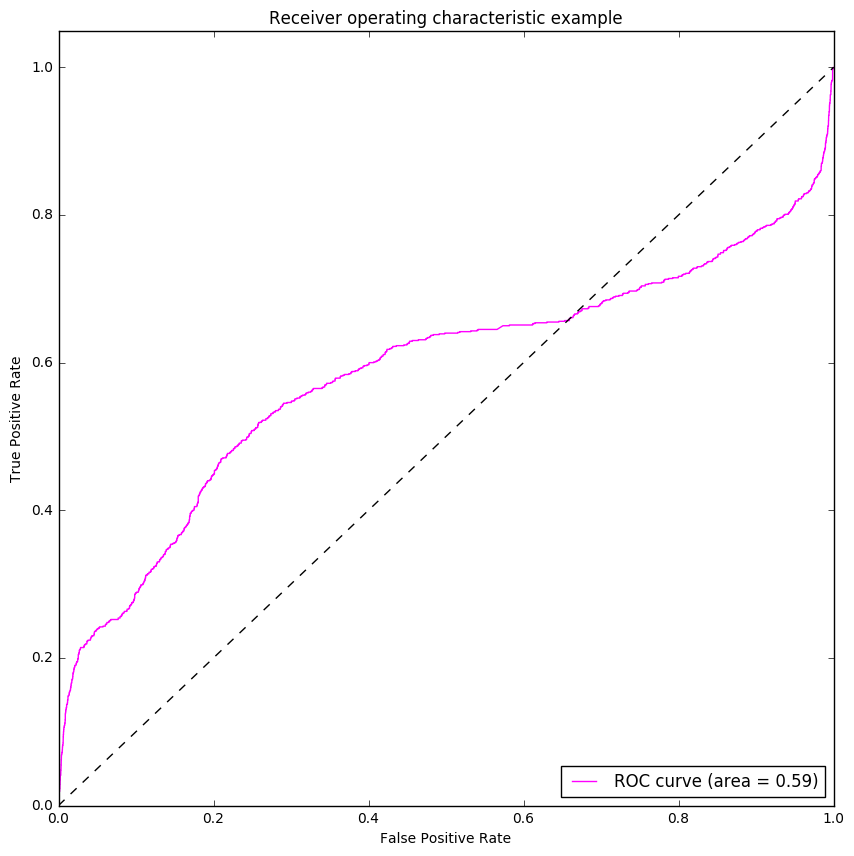

In [28]:
pred_f = np.array(pred).astype(float)
label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred)
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Area under the ROC curve : 0.627056


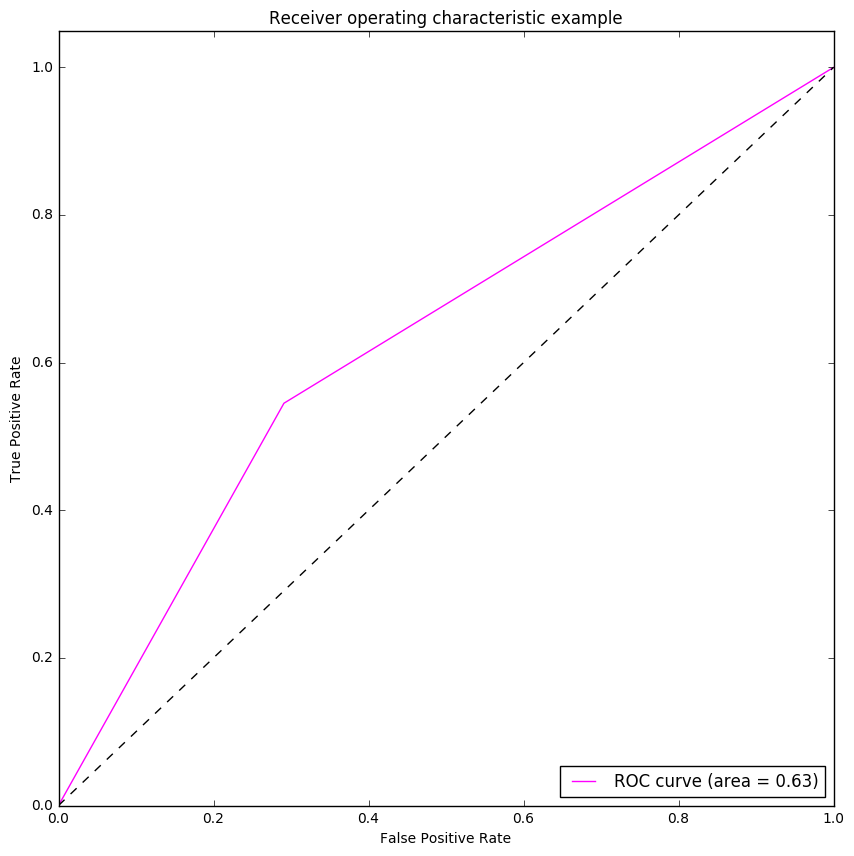

In [49]:
pred_b=[]
for p in pred_f:
    val = 0 if p < .000000005 else 1
    pred_b.append(val)

label = dftest['transaction']
fpr, tpr, thresholds = roc_curve(label, pred_b)
roc_auc = auc(fpr, tpr)
print "Area under the ROC curve : %f" % roc_auc
matplotlib.rcParams['figure.figsize'] = (10, 10)
plt.plot(fpr, tpr, color='magenta', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Area under the ROC curve : 0.586062


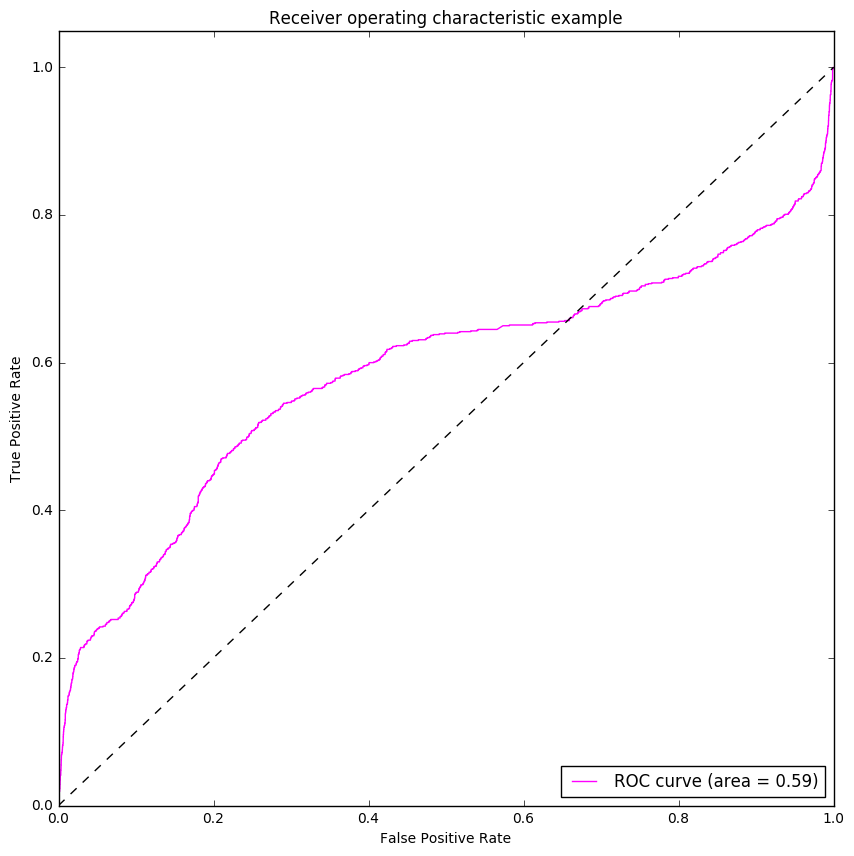